In [121]:
from tensorflow import keras
keras.__version__

'2.6.0'

In [122]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [123]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [124]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [125]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#base_dir = '/content/drive/MyDrive/Colab Notebooks/masked_face_git/Real-World-Masked-Face-Dataset/wear_mask_to_face'
# base_dir = '/content/drive/MyDrive/wear_mask_to_face'
base_dir = os.path.dirname(os.path.abspath("__file__"))
image_path = 'lfw-deepfunneled-result_ttv'
# image_path = 'AFDB_face_dataset_ttv'

train_dir = os.path.join(base_dir, 'images/' + image_path + '/train')
validation_dir = os.path.join(base_dir, 'images/' + image_path + '/val')
test_dir = os.path.join(base_dir, 'images/' + image_path + '/test')

In [126]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')


Found 4040 images belonging to 898 classes.
Found 1797 images belonging to 898 classes.


In [127]:
conv_base.trainable = True

for layer in conv_base.layers:
    if layer.name.find('block5_conv') > -1:
        print(layer.name)
        layer.trainable = True
        print(layer.trainable)
    else:
        layer.trainable = False
        print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
block5_conv1
True
block5_conv2
True
block5_conv3
True
False


In [128]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(898, activation='softmax'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               2097408   
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
dense_21 (Dense)             (None, 898)               230786    
Total params: 17,043,906
Trainable params: 9,408,130
Non-trainable params: 7,635,776
_________________________________________________________________


In [129]:
print('conv_base를 동결한 후 훈련되는 가중치 객체의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치 객체의 수: 12


In [130]:
import tensorflow

# fit() 메서드의 callbacks 매개변수를 사용하여 원하는 개수만큼 콜백을 모델로 전달
callback_list = [
    tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_acc', # 모델의 검증 정확도 모니터링
        patience=7, # 1 에포크보다 더 길게 향상되지 않으면 중단
    ),
    tensorflow.keras.callbacks.ModelCheckpoint(
        filepath='myquize1_model.checkpoint', # 저장
        monitor='val_loss',
        save_best_only=True, # 가장 좋은 모델
    )]

'''
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
'''

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc', 'top_k_categorical_accuracy'])

stepEpoch = 50
epoch = 44
valStep = 25

history = model.fit(
    train_generator,
    steps_per_epoch=stepEpoch,  # 100
    epochs=epoch,         ## 30
    validation_data=validation_generator,
    validation_steps=valStep,  ## 50
    callbacks=callback_list)

Epoch 1/44
50/50 [==============================] - 8s 135ms/step - loss: 6.8160 - acc: 0.0310 - top_k_categorical_accuracy: 0.0440 - val_loss: 6.9993 - val_acc: 0.0020 - val_top_k_categorical_accuracy: 0.0040
INFO:tensorflow:Assets written to: myquize1_model.checkpoint\assets
Epoch 2/44
50/50 [==============================] - 7s 130ms/step - loss: 6.4680 - acc: 0.0770 - top_k_categorical_accuracy: 0.1070 - val_loss: 6.7821 - val_acc: 0.0340 - val_top_k_categorical_accuracy: 0.0520
INFO:tensorflow:Assets written to: myquize1_model.checkpoint\assets
Epoch 3/44
50/50 [==============================] - 6s 124ms/step - loss: 6.2351 - acc: 0.1120 - top_k_categorical_accuracy: 0.1630 - val_loss: 6.6256 - val_acc: 0.0720 - val_top_k_categorical_accuracy: 0.1080
INFO:tensorflow:Assets written to: myquize1_model.checkpoint\assets
Epoch 4/44
50/50 [==============================] - 6s 120ms/step - loss: 6.0044 - acc: 0.1410 - top_k_categorical_accuracy: 0.2030 - val_loss: 6.5955 - val_acc: 0.06

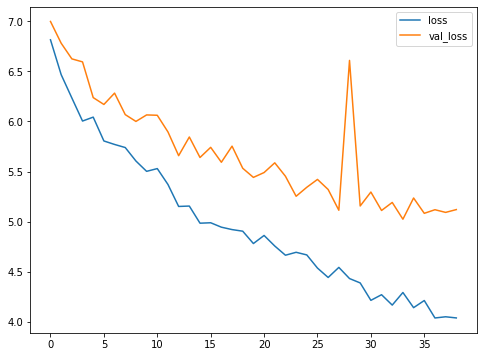

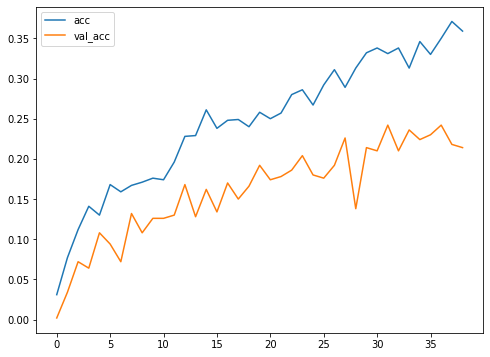

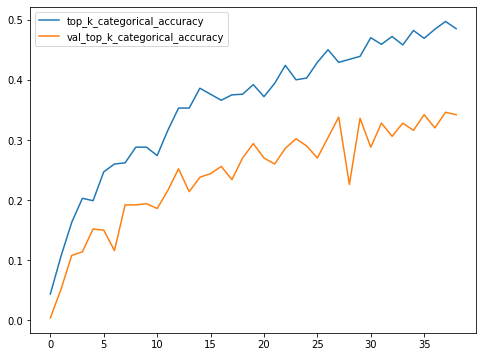

In [133]:
import pandas as pd
pic1 = pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(8, 6))
pic2 = pd.DataFrame(history.history)[['acc', 'val_acc']].plot(figsize=(8, 6))
pic3 = pd.DataFrame(history.history)[['top_k_categorical_accuracy', 'val_top_k_categorical_accuracy']].plot(figsize=(8, 6))

picFig1 = pic1.get_figure()
picFig2 = pic2.get_figure()
picFig3 = pic3.get_figure()

picPath = 'output_0910/step' + stepEpoch + '_ep'+ epoch+'_val'+ valStep

picFig1.savefig(picPath + '/output1.png')
picFig2.savefig(picPath + '/output2.png')
picFig3.savefig(picPath + '/output3.png')


In [132]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')  

test_loss, test_acc, test_top_k_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)
print('test top-5 acc:', test_top_k_acc)

Found 1635 images belonging to 898 classes.


D:\Program files\Anaconda\envs\recognition\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.23800000548362732
test top-5 acc: 0.34700000286102295
